# SAGEConv graph embeddings in PyG

In [ ]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
!pip install -q torch-cluster -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
!pip install -q torch-geometric

In [ ]:
!pip install umap-learn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_cluster import random_walk
from sklearn.linear_model import LogisticRegression

import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import NeighborSampler as RawNeighborSampler

import umap
import matplotlib.pyplot as plt
import seaborn as sns

EPS = 1e-15

In [ ]:
dataset = 'Cora'
path = './data'
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]

Processing...
Done!


In [ ]:
class NeighborSampler(RawNeighborSampler):
    def sample(self, batch):
        batch = torch.tensor(batch)
        row, col, _ = self.adj_t.coo()

        # For each node in `batch`, we sample a direct neighbor (as positive
        # example) and a random node (as negative example):
        pos_batch = random_walk(row, col, batch, walk_length=1,
                                coalesced=False)[:, 1]

        neg_batch = torch.randint(0, self.adj_t.size(1), (batch.numel(), ),
                                  dtype=torch.long)

        batch = torch.cat([batch, pos_batch, neg_batch], dim=0)
        return super(NeighborSampler, self).sample(batch)


train_loader = NeighborSampler(data.edge_index, sizes=[10, 10], batch_size=256,
                               shuffle=True, num_nodes=data.num_nodes)


class SAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers):
        super(SAGE, self).__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        
        for i in range(num_layers):
            in_channels = in_channels if i == 0 else hidden_channels
            self.convs.append(SAGEConv(in_channels, hidden_channels))

    def forward(self, x, adjs):
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x

    def full_forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != self.num_layers - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SAGE(data.num_node_features, hidden_channels=64, num_layers=2)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
x, edge_index = data.x.to(device), data.edge_index.to(device)


def train():
    model.train()

    total_loss = 0
    for batch_size, n_id, adjs in train_loader:
        # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
        adjs = [adj.to(device) for adj in adjs]
        optimizer.zero_grad()

        out = model(x[n_id], adjs)
        out, pos_out, neg_out = out.split(out.size(0) // 3, dim=0)

        pos_loss = F.logsigmoid((out * pos_out).sum(-1)).mean()
        neg_loss = F.logsigmoid(-(out * neg_out).sum(-1)).mean()
        loss = -pos_loss - neg_loss
        loss.backward()
        optimizer.step()

        total_loss += float(loss) * out.size(0)

    return total_loss / data.num_nodes


@torch.no_grad()
def test():
    model.eval()
    out = model.full_forward(x, edge_index).cpu()

    clf = LogisticRegression()
    clf.fit(out[data.train_mask], data.y[data.train_mask])

    val_acc = clf.score(out[data.val_mask], data.y[data.val_mask])
    test_acc = clf.score(out[data.test_mask], data.y[data.test_mask])

    return val_acc, test_acc


for epoch in range(1, 51):
    loss = train()
    val_acc, test_acc = test()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 001, Loss: 1.3851, Val: 0.2800, Test: 0.2640
Epoch: 002, Loss: 1.3150, Val: 0.4540, Test: 0.4740
Epoch: 003, Loss: 1.1678, Val: 0.6120, Test: 0.5960
Epoch: 004, Loss: 1.0871, Val: 0.6820, Test: 0.6610
Epoch: 005, Loss: 1.0651, Val: 0.6760, Test: 0.6900
Epoch: 006, Loss: 1.0652, Val: 0.6700, Test: 0.6840
Epoch: 007, Loss: 1.0308, Val: 0.6900, Test: 0.6960
Epoch: 008, Loss: 1.0040, Val: 0.7100, Test: 0.6990
Epoch: 009, Loss: 0.9966, Val: 0.6980, Test: 0.7200
Epoch: 010, Loss: 0.9980, Val: 0.7160, Test: 0.7270
Epoch: 011, Loss: 0.9881, Val: 0.6980, Test: 0.7170
Epoch: 012, Loss: 0.9735, Val: 0.7040, Test: 0.7050
Epoch: 013, Loss: 0.9633, Val: 0.7260, Test: 0.7160
Epoch: 014, Loss: 0.9538, Val: 0.7200, Test: 0.7290
Epoch: 015, Loss: 0.9399, Val: 0.7300, Test: 0.7360
Epoch: 016, Loss: 0.9270, Val: 0.7380, Test: 0.7400
Epoch: 017, Loss: 0.9400, Val: 0.7280, Test: 0.7350
Epoch: 018, Loss: 0.9517, Val: 0.7140, Test: 0.7430
Epoch: 019, Loss: 0.9493, Val: 0.7260, Test: 0.7420
Epoch: 020, 

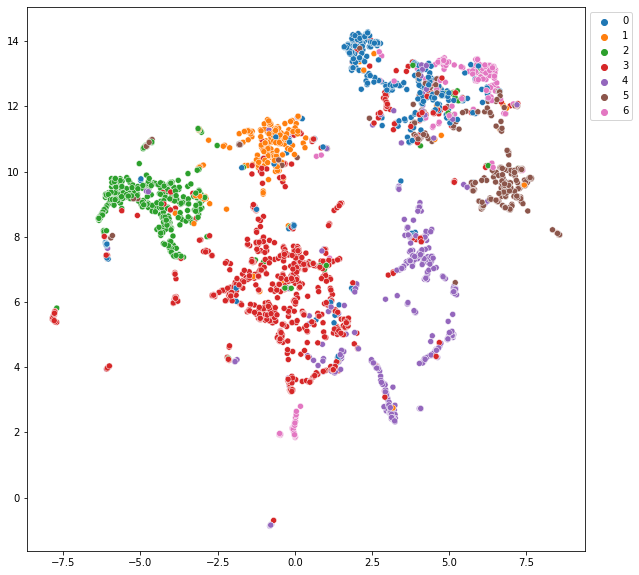

In [ ]:
with torch.no_grad():
    model.eval()
    out = model.full_forward(x, edge_index).cpu()

palette = {}
for n, y in enumerate(set(data.y.numpy())):
    palette[y] = f'C{n}'

embd = umap.UMAP().fit_transform(out.cpu().numpy())

plt.figure(figsize=(10, 10))
sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y.cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.savefig("umap_embd_sage.png", dpi=120)

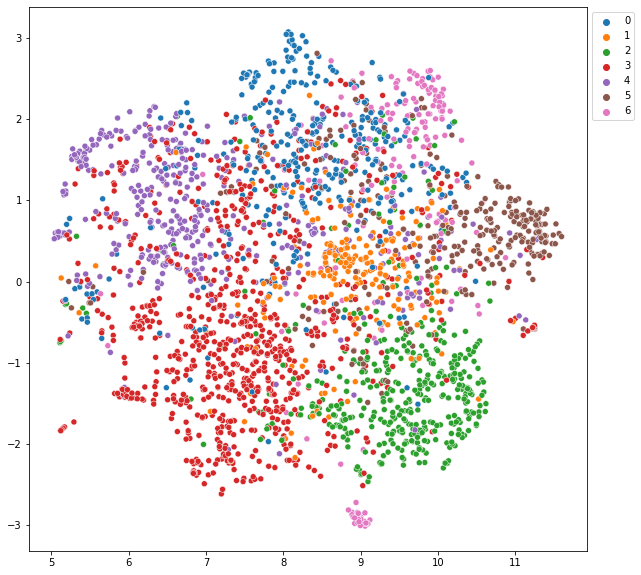

In [ ]:
embd_x = umap.UMAP().fit_transform(data.x.numpy())

plt.figure(figsize=(10, 10))
sns.scatterplot(x=embd_x.T[0], y=embd_x.T[1], hue=data.y.cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.savefig("umap_embd.png", dpi=120)